In [1]:
import sys
sys.path.append("../../dataprocessing")
import numpy as np
import os
import PIL
import PIL.Image
from PIL import ImageDraw
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm
import random
import data_process
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.spatial import distance

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

## 함수 정의

In [2]:
cd ../

c:\Users\jongm\OneDrive - 광운대학교\ProjecTS\Facial-Expression-Recognition\modeling


In [10]:
def cal_dist(data):
    landmark_matrixs, landmark_matrixs_df = [], []
    lp = [point[:-1] for point in data.columns if '-' in point]
    set_lp = sorted(set(lp), key = lambda x: lp.index(x))
    for idx, row in data.iterrows():
        temp_list = []
        len_x = row['right'] - row['left']
        len_y = row['bottom'] - row['top']
        for i in range(len(set_lp)):
            temp_list.append([row[set_lp[i]+'x'] / len_x, row[set_lp[i]+'y'] / len_y])
        temp = pd.DataFrame(distance.cdist(temp_list, temp_list, metric='euclidean'), index=set_lp, columns=set_lp)
        landmark_matrixs.append(temp)
        landmark_matrixs_df.append(temp.to_numpy()[np.triu_indices(len(set_lp), 1)])
    return landmark_matrixs, pd.DataFrame(landmark_matrixs_df)

In [4]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        # if data.columns[idx] == 'frame':
        #     continue
        if data.columns[idx][:-1] in target_landmark:
            # print(x,y)
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        else:
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [5]:
def show_diff(*args):
    data = args[0]
    window = args[1]
    erase_list = ['frame','left','top','right','bottom','time_diff']
    data3 = data[[point for point in data.columns if '-' in point] + erase_list]

    if len(args) == 3:
        idxs = args[2]
        i = 0
        for idx in idxs:
            if i == 0:
                data2 = data[[point for point in data.columns if str(idx) == point.split('-')[0]]]
            else:
                data2 = pd.concat([data2, data[[point for point in data.columns if str(idx) == point.split('-')[0]]]], axis=1)
            i += 1
        data2 = pd.concat([data2, data[erase_list]], axis=1)
        # print(data2.columns)
    else:
        data2 = data3.copy()

    # print(list(set(data.columns) - set(erase_list)))
    remain_list = sorted(list(set(data2.columns) - set(erase_list)))
    diff_df = pd.DataFrame(columns=list(range(len(data2))), index=list(set([c[:-1] for c in remain_list])))

    # print(data2, remain_list)    
    for row in range(0, len(remain_list), 2):
        init_point = [data2.iloc[0][remain_list[row]], data2.iloc[0][remain_list[row+1]]]
        # print(remain_list[col], remain_list[col+1])
        temp2 = 0.0
        # diff_df[remain_list[col][:-1]] = 0
        for col in range(len(data2)):    
            # print(init_point, data.loc[col][remain_list[row]], data.loc[col][remain_list[row+1]])    
            temp = distance.euclidean(init_point, [data2.loc[col][remain_list[row]], data2.loc[col][remain_list[row+1]]])
            temp2 += temp
            # for start in range(0,len(data.index), window):
            #     # print(max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col]), max(data.iloc[start:start+5][col]), min(data.iloc[start:start+5][col]))
            #     temp += max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col])
            diff_df.at[remain_list[row][:-1], col] = temp
        diff_df.at[remain_list[row][:-1], 'sum'] = temp2
        # print(remain_list[col] + ", "+ remain_list[col+1])
    return diff_df.sort_values('sum', ascending=False), data3

In [6]:
def make_flow_chart(data, diff_df, part, order, image_order, path):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (20,10))
    # sort = diff_df.iloc[:order]
    # print(diff_df)
    if type(order) == int:        
        diff_df = diff_df.drop(['sum'], axis=1)
        new_data = diff_df.iloc[:order]
    elif type(order) == list:
        diff_df = diff_df.drop(['class'], axis=1)
        new_data = diff_df[order]
        new_data = new_data.transpose()
    # print(new_data.index)
    # new_data = new_data[[point for point in new_data.columns if str(part) == point.split('-')[0]]]
    temp_plot = sns.lineplot(data = new_data.transpose(), markers=False, dashes=False)  
    # print(path+str(image_order) + '.0.jpg')
    show_img(data, path + str(image_order) + '.0.jpg', new_data)
    # ax[idx, col].set_title(str(idx) +" 번 클러스터")
    # if col==0:        
    #     ax[idx, col].set_ylabel(list(custom_sort.keys())[idx])
    #     ax[idx, col].yaxis.label.set_size(20)
    # ax[idx].set_ylabel(list(custom_sort.keys())[idx] + " group")
    # ax[idx].set_xticks(list(range(1,len(seq)+1)))        
    # for row in data.iterrows():
    #     ax[idx].text(row[0], int(row[1]['quiz']), int(row[1]['quiz']), fontsize=12, ha='center') 
    #     ax[idx].text(row[0], int(row[1]['proj']), int(row[1]['proj']), fontsize=12, ha='center')

In [7]:
def predict(data_path1, data_path2, model):
    landmarks = pd.read_csv(data_path1)
    landmarks2 = pd.read_csv(data_path2)
    landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
    landmark_matrixs_df['class'] = 0
    landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
    landmark_matrixs_df2['class'] = 1
    df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
    length_i = len(landmark_matrixs[0].columns)
    start = 1
    name_list = []
    for i in landmark_matrixs[0].index:
        for j in range(start, length_i):
            name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
        start += 1

    X = df.drop(['class'], axis=1)
    X = X.astype('float')
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

    if model == 'rf':
        set_model = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=2022, oob_score=True)
    elif model == 'xgboost':
        set_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    set_model.fit(X_train, y_train)
    pred = set_model.predict(X_test)
    print(confusion_matrix(y_test, pred))
    # accuracy = accuracy_score(y_test, pred)
    # print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))
    print('훈련세트 정확도: {:.3f}' .format(set_model.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(set_model.score(X_test, y_test)))
    importance = pd.DataFrame({'landmarks': name_list, 'importance': set_model.feature_importances_})
    importance = importance.sort_values('importance',ascending=False)
    importance = importance.astype({'landmarks':'str'})
    print(importance)
    return landmarks2, importance

In [8]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        if data.columns[idx] == 'frame':
            continue
        cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
        # if data.columns[idx][:-1] in target_landmark:
        #     # print(x,y)
        #     cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        # else:
    for point_pair in landmark_points:
        x1 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[0]+'x']
        y1 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[0]+'y']
        x2 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[1]+'x']
        y2 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[1]+'y']
        cv2.line(drawing_image, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), radius)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

> 0은 얼굴 테두리 \
> 1, 2는 왼쪽 눈썹 위, 아래 \
> 3, 4는 오른쪽 눈썹 위, 아래 \
> 5, 6은 왼쪽, 오른쪽 눈 \
> 7, 8은 위쪽 입술 윗부분, 아래부분 \
> 9, 10은 아래쪽 입술 윗부분, 아래부분 \
> 11은 코 세로축 \
> 12는 코 아래부분

## 1. 눈썹 들어올리기

In [11]:
landmarks = pd.read_csv('../data/images/중립/202209.03105902855.csv')
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs[0]

0-0       0-1       0-2       0-3       0-4       0-5       0-6  \
0-0   0.000000  0.073260  0.205636  0.300392  0.370414  0.436699  0.483093   
0-1   0.073260  0.000000  0.132656  0.228319  0.300855  0.370908  0.422017   
0-2   0.205636  0.132656  0.000000  0.097168  0.175216  0.253143  0.314098   
0-3   0.300392  0.228319  0.097168  0.000000  0.082288  0.165560  0.233689   
0-4   0.370414  0.300855  0.175216  0.082288  0.000000  0.084530  0.155845   
...        ...       ...       ...       ...       ...       ...       ...   
12-0  0.630206  0.644104  0.675257  0.691930  0.680781  0.658925  0.623807   
12-1  0.635421  0.638791  0.651683  0.655751  0.634603  0.603179  0.560831   
12-2  0.632914  0.625236  0.618669  0.609370  0.578041  0.537053  0.487756   
13-0  0.642633  0.670427  0.724505  0.756542  0.757737  0.747504  0.721165   
14-0  0.646205  0.622516  0.585984  0.555073  0.507453  0.450795  0.390213   

           0-7       0-8       0-9  ...      10-6      10-7      10-8  \
0-0   0.540367  0.599168  0.657725  ...  0.810529  0.798680  0.786500   
0-1   0.485983  0.551110  0.615575  ...  0.818764  0.809692  0.799360   
0-2   0.391232  0.467936  0.542743  ...  0.835721  0.831746  0.824878   
0-3   0.319758  0.403674  0.484708  ...  0.838984  0.838791  0.834558   
0-4   0.246270  0.333707  0.417884  ...  0.814792  0.817720  0.815719   
...        ...       ...       ...  ...       ...       ...       ...   
12-0  0.575436  0.533649  0.498302  ...  0.186433  0.169675  0.156311   
12-1  0.503805  0.454081  0.412127  ...  0.184134  0.183351  0.181462   
12-2  0.422526  0.365447  0.318089  ...  0.242297  0.252366  0.257246   
13-0  0.682934  0.649901  0.621454  ...  0.256282  0.227327  0.205192   
14-0  0.310826  0.239201  0.179679  ...  0.363147  0.379848  0.388767   

          11-0      11-1      12-0      12-1      12-2      13-0      14-0  
0-0   0.310491  0.595679  0.630206  0.635421  0.632914  0.642633  0.646205  
0-1   0.318174  0.600614  0.644104  0.638791  0.625236  0.670427  0.622516  
0-2   0.358080  0.617591  0.675257  0.651683  0.618669  0.724505  0.585984  
0-3   0.394113  0.625565  0.691930  0.655751  0.609370  0.756542  0.555073  
0-4   0.407431  0.608209  0.680781  0.634603  0.578041  0.757737  0.507453  
...        ...       ...       ...       ...       ...       ...       ...  
12-0  0.326151  0.085605  0.000000  0.092213  0.186813  0.129470  0.326985  
12-1  0.324930  0.041204  0.092213  0.000000  0.095852  0.221670  0.237196  
12-2  0.329283  0.110083  0.186813  0.095852  0.000000  0.315535  0.141470  
13-0  0.366524  0.209072  0.129470  0.221670  0.315535  0.000000  0.454270  
14-0  0.374299  0.245448  0.326985  0.237196  0.141470  0.454270  0.000000  

[133 rows x 133 columns]

In [9]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'rf')

[[11  0]
 [ 0 11]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
5483    4-0 ↔ 6-6    0.040000
5235    3-2 ↔ 6-4    0.026841
5486    4-0 ↔ 6-9    0.024211
5151    3-1 ↔ 6-4    0.020000
5069    3-0 ↔ 6-7    0.020000
...           ...         ...
2951  0-24 ↔ 6-12    0.000000
2950  0-24 ↔ 6-11    0.000000
2949  0-24 ↔ 6-10    0.000000
2948   0-24 ↔ 6-9    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


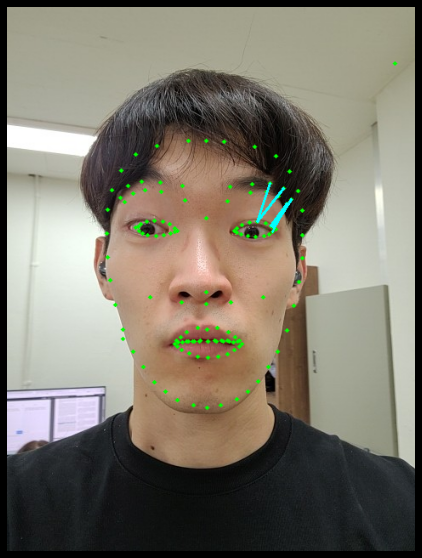

In [10]:
face = '눈썹들어올리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [11]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'xgboost')

[[11  0]
 [ 0 11]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
5068    3-0 ↔ 6-6         1.0
0       0-0 ↔ 0-1         0.0
5855    5-0 ↔ 5-4         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
2917   0-24 ↔ 3-4         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


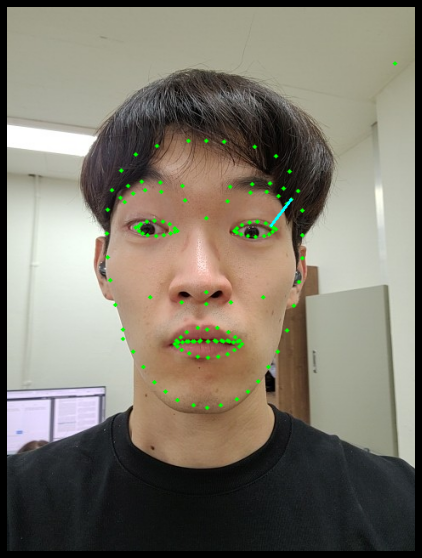

In [12]:
face = '눈썹들어올리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 3. 두 눈 감기

In [13]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈감기+1/202209.03105914019.csv', 'rf')

[[12  1]
 [ 0 12]]
훈련세트 정확도: 1.000
테스트세트 정확도: 0.960
        landmarks  importance
5806   4-4 ↔ 6-15    0.017258
5566    4-1 ↔ 6-9    0.017185
4771   2-1 ↔ 13-0    0.017098
4525   1-4 ↔ 5-10    0.016768
5409   3-4 ↔ 6-13    0.015834
...           ...         ...
2974   0-24 ↔ 8-8    0.000000
2973   0-24 ↔ 8-7    0.000000
2972   0-24 ↔ 8-6    0.000000
2971   0-24 ↔ 8-5    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


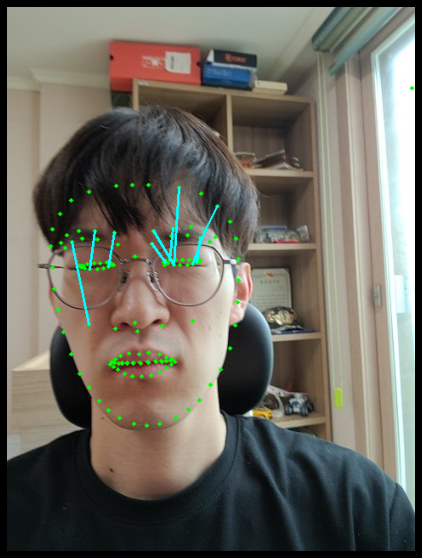

In [14]:
face = '두눈감기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:10]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [16]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈감기+1/202209.03105914019.csv', 'xgboost')

[[13  0]
 [ 0 12]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
4343   1-2 ↔ 5-13    0.555967
5646   4-2 ↔ 6-10    0.147774
1981  0-15 ↔ 10-5    0.044089
1731   0-13 ↔ 8-8    0.040993
1992  0-16 ↔ 0-17    0.038147
...           ...         ...
2926   0-24 ↔ 5-3    0.000000
2925   0-24 ↔ 5-2    0.000000
2924   0-24 ↔ 5-1    0.000000
2923   0-24 ↔ 5-0    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


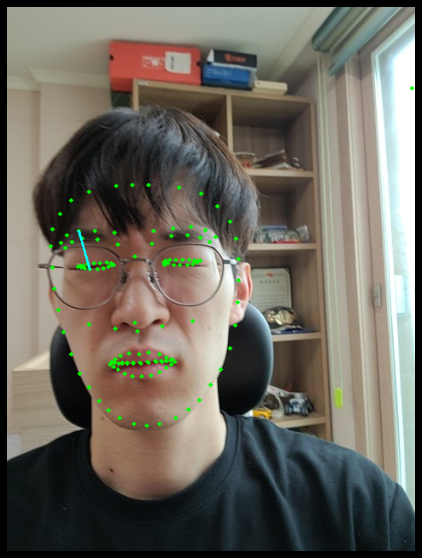

In [17]:
face = '두눈감기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 4. 두 눈 크게 뜨기

In [17]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈크게뜨기+1/202209.03152411046.csv', 'rf')

[[14  0]
 [ 0 13]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
6358   5-6 ↔ 12-0    0.027998
6085   5-3 ↔ 5-12    0.019260
6108    5-3 ↔ 7-3    0.018663
6262    5-5 ↔ 8-3    0.018101
6133    5-3 ↔ 9-8    0.017767
...           ...         ...
2948   0-24 ↔ 6-9    0.000000
2947   0-24 ↔ 6-8    0.000000
2946   0-24 ↔ 6-7    0.000000
2945   0-24 ↔ 6-6    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


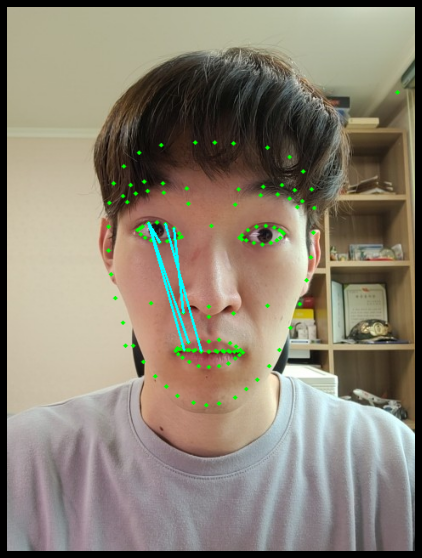

In [18]:
face = '두눈크게뜨기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [19]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈크게뜨기+1/202209.03152411046.csv', 'xgboost')

[[13  1]
 [ 1 12]]
훈련세트 정확도: 1.000
테스트세트 정확도: 0.926
        landmarks  importance
6086   5-3 ↔ 5-13    0.949864
6251    5-5 ↔ 7-3    0.050136
5852    5-0 ↔ 5-1    0.000000
5847   4-4 ↔ 12-0    0.000000
5848   4-4 ↔ 12-1    0.000000
...           ...         ...
2920   0-24 ↔ 4-2    0.000000
2919   0-24 ↔ 4-1    0.000000
2918   0-24 ↔ 4-0    0.000000
2917   0-24 ↔ 3-4    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


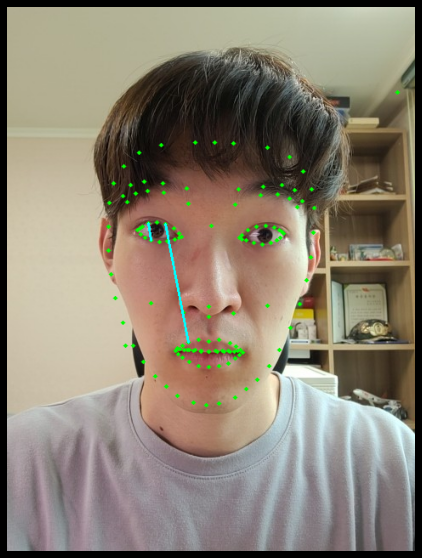

In [21]:
face = '두눈크게뜨기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:2]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 9. 입벌리기

In [24]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입벌리기+1/202209.05132412050.csv', 'rf')

[[12  0]
 [ 0 11]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
8378    8-5 ↔ 9-3    0.030777
8026   7-5 ↔ 10-5    0.020000
8438   8-7 ↔ 10-1    0.020000
8696  10-2 ↔ 12-1    0.020000
8302   8-2 ↔ 10-5    0.020000
...           ...         ...
2928   0-24 ↔ 5-5    0.000000
2927   0-24 ↔ 5-4    0.000000
2926   0-24 ↔ 5-3    0.000000
2925   0-24 ↔ 5-2    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


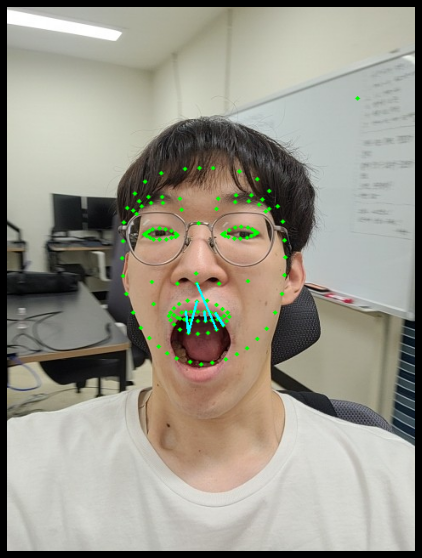

In [25]:
face = '입벌리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [26]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입벌리기+1/202209.05132412050.csv', 'xgboost')

[[12  0]
 [ 0 11]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
564     0-4 ↔ 3-1         1.0
0       0-0 ↔ 0-1         0.0
5847   4-4 ↔ 12-0         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2921   0-24 ↔ 4-3         0.0
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


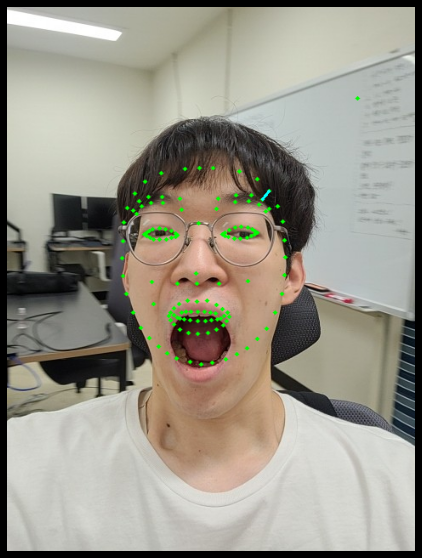

In [27]:
face = '입벌리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 10. 입술 오므리기

In [28]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술오므리기+1/202209.05132437930.csv', 'rf')

[[10  0]
 [ 0  9]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
8696  10-2 ↔ 12-1        0.04
8378    8-5 ↔ 9-3        0.03
7906   7-2 ↔ 10-5        0.03
8583   9-4 ↔ 12-0        0.02
8242   8-0 ↔ 10-8        0.02
...           ...         ...
2923   0-24 ↔ 5-0        0.00
2922   0-24 ↔ 4-4        0.00
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


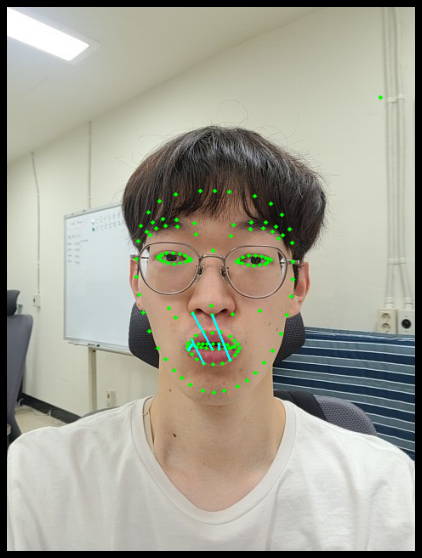

In [29]:
face = '입술오므리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [18]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술오므리기+1/202209.05132437930.csv', 'xgboost')

[[10  0]
 [ 0  9]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
2210  0-17 ↔ 10-3    0.938667
39      0-0 ↔ 1-4    0.061333
0       0-0 ↔ 0-1    0.000000
5854    5-0 ↔ 5-3    0.000000
5849   4-4 ↔ 12-2    0.000000
...           ...         ...
2921   0-24 ↔ 4-3    0.000000
2920   0-24 ↔ 4-2    0.000000
2919   0-24 ↔ 4-1    0.000000
2918   0-24 ↔ 4-0    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


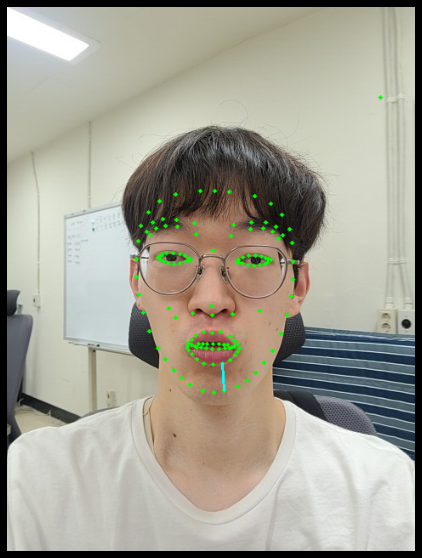

In [19]:
face = '입술오므리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 16. 미소짓기

In [32]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/미소짓기+1/202209.05132448886.csv', 'rf')

[[11  0]
 [ 0 10]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
7995   7-4 ↔ 12-2        0.02
8247   8-0 ↔ 12-2        0.02
8680  10-1 ↔ 11-0        0.02
7687  6-13 ↔ 10-6        0.01
3716  0-31 ↔ 10-4        0.01
...           ...         ...
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
2917   0-24 ↔ 3-4        0.00
2916   0-24 ↔ 3-3        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


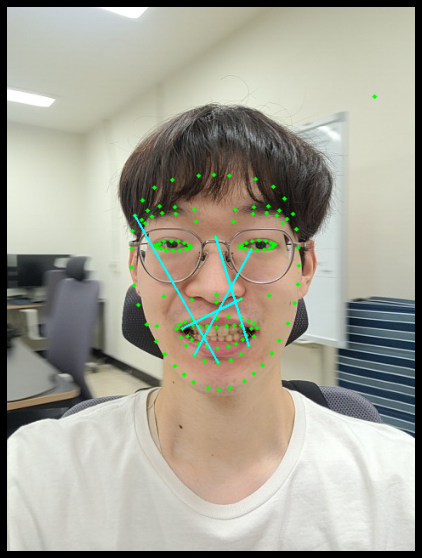

In [33]:
face = '미소짓기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [34]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/미소짓기+1/202209.05132448886.csv', 'xgboost')

[[11  0]
 [ 0 10]]
훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
867     0-6 ↔ 7-9         1.0
0       0-0 ↔ 0-1         0.0
5848   4-4 ↔ 12-1         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2921   0-24 ↔ 4-3         0.0
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


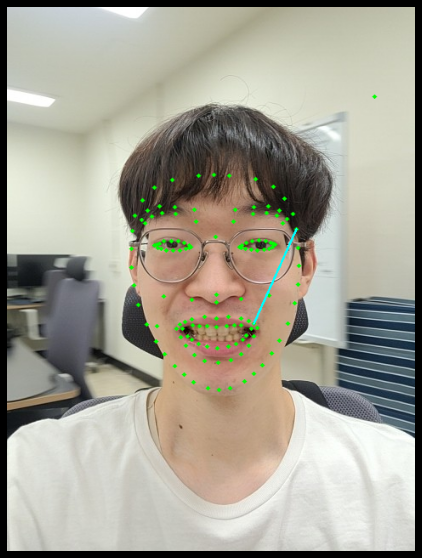

In [35]:
face = '미소짓기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)